In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import AerPauliExpectation, PauliExpectation
from qiskit.providers.aer import AerSimulator

from src.expectation import Expectation
from src.fidelity import Fidelity

from src.gradients import ExpectationParameterShift, FidelityParameterShift
from src.gradients import ExpectationReverse, FidelityReverse

from experiments.models.heisenline import get_model
from src.dual import DualITE
from src.optimizers import GradientDescent, SPSA

In [3]:
hamiltonian, circuit, initial_parameters = get_model(num_sites=12, J=0.25, g=-1, reps=3)

In [4]:
print(hamiltonian)

0.25 * IIIIIIIIIIXX
+ 0.25 * IIIIIIIIIXXI
+ 0.25 * IIIIIIIIXXII
+ 0.25 * IIIIIIIXXIII
+ 0.25 * IIIIIIXXIIII
+ 0.25 * IIIIIXXIIIII
+ 0.25 * IIIIXXIIIIII
+ 0.25 * IIIXXIIIIIII
+ 0.25 * IIXXIIIIIIII
+ 0.25 * IXXIIIIIIIII
+ 0.25 * XXIIIIIIIIII
+ 0.25 * IIIIIIIIIIYY
+ 0.25 * IIIIIIIIIYYI
+ 0.25 * IIIIIIIIYYII
+ 0.25 * IIIIIIIYYIII
+ 0.25 * IIIIIIYYIIII
+ 0.25 * IIIIIYYIIIII
+ 0.25 * IIIIYYIIIIII
+ 0.25 * IIIYYIIIIIII
+ 0.25 * IIYYIIIIIIII
+ 0.25 * IYYIIIIIIIII
+ 0.25 * YYIIIIIIIIII
+ 0.25 * IIIIIIIIIIZZ
+ 0.25 * IIIIIIIIIZZI
+ 0.25 * IIIIIIIIZZII
+ 0.25 * IIIIIIIZZIII
+ 0.25 * IIIIIIZZIIII
+ 0.25 * IIIIIZZIIIII
+ 0.25 * IIIIZZIIIIII
+ 0.25 * IIIZZIIIIIII
+ 0.25 * IIZZIIIIIIII
+ 0.25 * IZZIIIIIIIII
+ 0.25 * ZZIIIIIIIIII
- 1.0 * IIIIIIIIIIIZ
- 1.0 * IIIIIIIIIIZI
- 1.0 * IIIIIIIIIZII
- 1.0 * IIIIIIIIZIII
- 1.0 * IIIIIIIZIIII
- 1.0 * IIIIIIZIIIII
- 1.0 * IIIIIZIIIIII
- 1.0 * IIIIZIIIIIII
- 1.0 * IIIZIIIIIIII
- 1.0 * IIZIIIIIIIII
- 1.0 * IZIIIIIIIIII
- 1.0 * ZIIIIIIIIIII


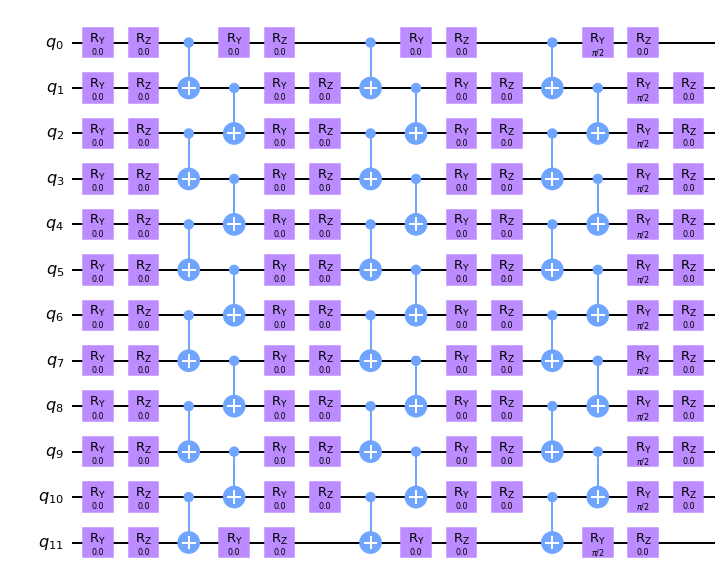

In [5]:
circuit.bind_parameters(initial_parameters).decompose().draw("mpl")

In [29]:
opt = GradientDescent(maxiter=100, learning_rate=0.1, losstol=0, gradtol=0, momentum=0.)

In [17]:
# opt = SPSA(maxiter=100, learning_rate=0.1, perturbation=0.1)

In [18]:
backend = AerSimulator(method="statevector")
expectation_converter = AerPauliExpectation()
shots = None
expectation_gradient = ExpectationReverse()
fidelity_gradient = FidelityReverse()
expectation = Expectation(backend, expectation_converter, hamiltonian, shots=shots)
fidelity = Fidelity(backend, expectation_converter, shots=shots)

In [30]:
sv_algo = DualITE(
    circuit,
    initial_parameters,
    expectation,
    fidelity,
    expectation_gradient,
    fidelity_gradient,
    warmstart=False,
    optimizer=opt,
    timestep_normalization=True,
    norm_factor=0,
)

In [31]:
backend = AerSimulator()
expectation_converter = PauliExpectation()
shots = 1000
expectation_gradient = ExpectationParameterShift()
fidelity_gradient = FidelityParameterShift()

In [32]:
expectation = Expectation(backend, expectation_converter, hamiltonian, shots=shots)
fidelity = Fidelity(backend, expectation_converter, shots=shots)

In [33]:
algo = DualITE(
    circuit,
    initial_parameters,
    expectation,
    fidelity,
    expectation_gradient,
    fidelity_gradient,
    warmstart=False,
    optimizer=opt,
    timestep_normalization=True,
    norm_factor=0,
)

In [34]:
dt = 0.01
theta = initial_parameters
x0 = np.zeros_like(theta) + 0.01

In [35]:
next_theta, thetas, losses, grads = algo.step(dt, theta, x0)

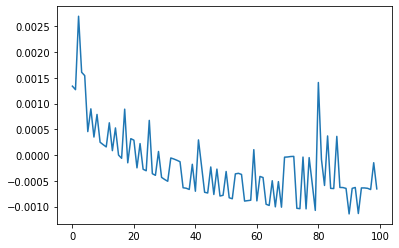

In [36]:
plt.plot(losses)

In [37]:
exloss = sv_algo.get_loss_and_gradient(dt, theta)

In [38]:
exlosses = [exloss(theta_i - theta, return_gradient=False) for theta_i in thetas]

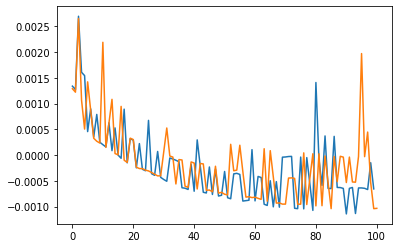

In [39]:
plt.plot(losses)
plt.plot(exlosses)

4 qubits, 100 shots, 1000 it, eta 0.01

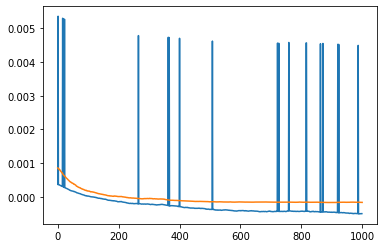

In [87]:
plt.plot(losses)
plt.plot(exlosses)

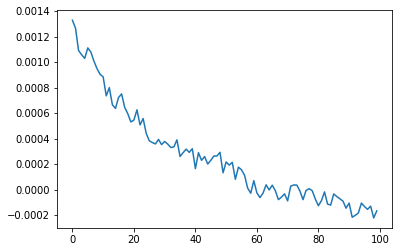

In [75]:
plt.plot(losses)

In [77]:
10**5 / 2 ** 12

24.4140625

In [114]:
backend = AerSimulator()
expectation_converter = PauliExpectation()
shots = 10_000
fidelity = Fidelity(backend, expectation_converter, circuit, circuit, shots=shots)

In [122]:
expectation = Expectation(backend, expectation_converter, hamiltonian, circuit, shots=shots)
expectation_gradient = ExpectationParameterShift(expectation)
grad = expectation_gradient.compute(theta)

In [123]:
grad

array([-0.0249  ,  0.0297  ,  0.012175,  0.00845 ,  0.02075 , -0.004325,
        0.0089  ,  0.985225,  0.00215 ,  0.024375, -0.010425,  0.0133  ,
        0.0316  ,  0.016425, -0.0087  , -0.0206  , -0.026125, -0.02465 ,
        0.050425,  0.0046  , -0.01185 , -0.020825,  1.00345 ,  0.98635 ,
       -0.017725, -0.0123  ,  0.014525, -0.01125 , -0.0163  , -0.02335 ,
        0.018225,  0.003575,  0.018525, -0.036075,  0.006875,  0.0104  ,
       -0.034675, -0.01745 , -0.027275,  0.976975, -0.015225, -0.016175,
       -0.0107  , -0.017525,  0.020275, -0.028625,  0.047425,  0.02275 ,
        1.01065 ,  1.0069  ,  1.009375,  0.970875,  0.988725,  0.978375,
        0.97725 ,  1.0238  ,  0.0278  ,  0.06835 , -0.008475, -0.023925,
        0.001475, -0.008025, -0.0171  , -0.0094  ])

In [128]:
direction = np.ones_like(theta)
dist = 0.1
pert = np.linspace(0, dist, 100) - dist / 2
infids = [1 - fidelity.evaluate(theta, theta + pert_i * direction) for pert_i in pert]

grads = -0.5 * np.dot(grad, direction) * pert 

Text(0, 0.5, 'F')

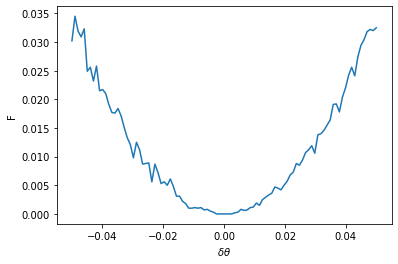

In [129]:
plt.plot(pert, infids)
plt.xlabel(r"$\delta\theta$")
plt.ylabel("F")

Text(0, 0.5, 'E')

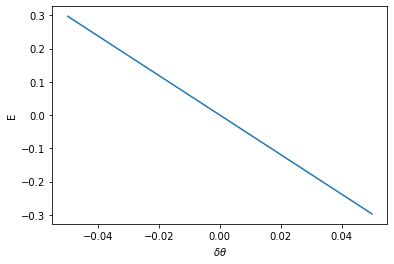

In [130]:
plt.plot(pert, grads)
plt.xlabel(r"$\delta\theta$")
plt.ylabel("E")

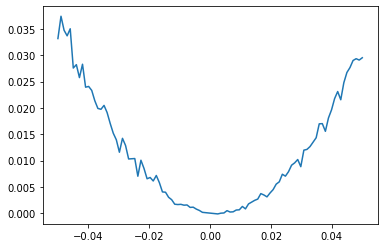

In [131]:
plt.plot(pert, dt * grads + infids)